## IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

## DATA PRE-PROCESSING

In [3]:
# Creating a dataframe from the provided dataset
df = pd.read_csv("Final.csv")
# Filling missing values with NaN
df.fillna("NaN", inplace=True)
# Changing the format of the ORDER_CREATION_DATE and REQUESTED_DELIVERY_DATE
df["ORDER_CREATION_DATE"] = pd.to_datetime(df["ORDER_CREATION_DATE"], format="%Y%m%d")
df["REQUESTED_DELIVERY_DATE"] = pd.to_datetime(df["REQUESTED_DELIVERY_DATE"], format="%Y%m%d")
#  Removing those records where order date is greater than the delivery date 
df.drop(df[(df["ORDER_CREATION_DATE"] > df["REQUESTED_DELIVERY_DATE"])].index, inplace=True)
# Replacing - and , with with appropriate symbols for ORDER_AMOUNT and RELEASED_CREDIT_VALUE 
df["ORDER_AMOUNT"] = df["ORDER_AMOUNT"].str.replace("-", "")
df["ORDER_AMOUNT"] = df["ORDER_AMOUNT"].str.replace(",", ".")
df["RELEASED_CREDIT_VALUE"] = df["RELEASED_CREDIT_VALUE"].str.replace("-", "")
df["RELEASED_CREDIT_VALUE"] = df["RELEASED_CREDIT_VALUE"].str.replace(",", ".")
# Replacing HU1 to HUF as no currency with name HU1 exists
df["ORDER_CURRENCY"] = df["ORDER_CURRENCY"].replace("HU1", "HUF")
# Converting ORDER_AMOUNT to amount_in_usd by using openexchangerates.org API to get realtime exchange rates
apikey = "347adc49463e4adfafd55bba3192ed32"
url = f"https://openexchangerates.org/api/latest.json?app_id={apikey}"
response = requests.get(url)
data = response.json()
exchange_rates = data["rates"]
def convert_to_usd(row):
    amount = row['ORDER_AMOUNT']
    currency = row['ORDER_CURRENCY']
    if currency != 'USD':
        return float(amount) / exchange_rates.get(currency, 1)
    return amount
df['amount_in_usd'] = df.apply(convert_to_usd, axis=1)
# Creating a new column UNIQUE_CUST_ID by combining CUSTOMER_NUMBER and COMPANY_CODE
df["UNIQUE_CUST_ID"] = df["CUSTOMER_NUMBER"].astype(str) + df["COMPANY_CODE"].astype(str)
# Sorting the dataset based on the ORDER_CREATION_DATE
df.sort_values('ORDER_CREATION_DATE',inplace=True)

In [5]:
df.head(8)

,CUSTOMER_ORDER_ID,SALES_ORG,DISTRIBUTION_CHANNEL,DIVISION,RELEASED_CREDIT_VALUE,PURCHASE_ORDER_TYPE,COMPANY_CODE,ORDER_CREATION_DATE,ORDER_CREATION_TIME,CREDIT_CONTROL_AREA,SOLD_TO_PARTY,ORDER_AMOUNT,REQUESTED_DELIVERY_DATE,ORDER_CURRENCY,CREDIT_STATUS,CUSTOMER_NUMBER,amount_in_usd,UNIQUE_CUST_ID
0,946851639,3537,United States of America,South-Region,0.00,1000,3220,2022-01-01,43012,SR02,756141537,954.61,2022-01-13,EUR,NaN,12311807,1042.924879,123118073220
1006847,995549949,3559,Bhutan,South-Region,0.00,DFUE,3030,2022-01-01,180014,SR02,791082697,2610.00,2022-01-01,HKD,NaN,1210509823,333.76753,12105098233030
1006848,869122376,3043,Mexico,South-Region,0.00,DFUE,3030,2022-01-01,180016,NR04,872170869,5848.50,2022-01-01,HKD,NaN,1210431200,747.907815,12104312003030
1006849,907014963,3391,Congo,South-Region,0.00,DFUE,3030,2022-01-01,180017,SR03,849650735,6045.17,2022-01-01,HKD,NaN,1210408844,773.058029,12104088443030
1006850,804194459,2215,Wallis and Futuna,South-Region,0.00,DFUE,3030,2022-01-01,180016,SR01,891200832,8736.00,2022-01-01,HKD,NaN,1210430743,1117.162122,12104307433030
1006851,901342633,3098,Armenia,South-Region,0.00,DFUE,3030,2022-01-01,180031,NR01,807417709,4229.89,2022-01-01,HKD,NaN,1210345599,540.919515,12103455993030
1006852,980177992,2771,Belarus,South-Region,0.00,DFUE,3030,2022-01-01,180038,SR01,953155740,9630.16,2022-01-01,HKD,NaN,1210408843,1231.507552,12104088433030
1006853,966470307,3849,Antarctica (the territory South of 60 deg S),South-Region,0.00,DFUE,3030,2022-01-01,180055,NR04,955050596,7592.51,2022-01-01,HKD,NaN,1210407236,970.932301,12104072363030


In [102]:
# Converting the datatypes of the columns 
df['RELEASED_CREDIT_VALUE'] = df['RELEASED_CREDIT_VALUE'].astype(float)
df['amount_in_usd']=df['amount_in_usd'].astype(float)
df['DISTRIBUTION_CHANNEL'] = df['DISTRIBUTION_CHANNEL'].astype(str)
df['DIVISION'] = df['DIVISION'].astype(str)
df['PURCHASE_ORDER_TYPE'] = df['PURCHASE_ORDER_TYPE'].astype(str)
df['CREDIT_CONTROL_AREA'] = df['CREDIT_CONTROL_AREA'].astype(str)
df['CREDIT_STATUS'] = df['CREDIT_STATUS'].astype(str)

## DATA SPLITTING

In [103]:
# Creating two new columns ORDER_MONTH and ORDER_DATE
df['ORDER_MONTH'] = df['ORDER_CREATION_DATE'].dt.month
df['ORDER_DATE'] = df['ORDER_CREATION_DATE'].dt.day
# Splitting the data based on months using first four months as train and last four as test
monthly_data = {}
for month in range(1, 13):
    monthly_data[month] = df[df['ORDER_MONTH'] == month]
train_data = pd.concat([monthly_data[1],monthly_data[2],monthly_data[3],monthly_data[4]], ignore_index=True)
test_data = pd.concat([monthly_data[5],monthly_data[6]], ignore_index=True)

## EDA and Feature Engineering

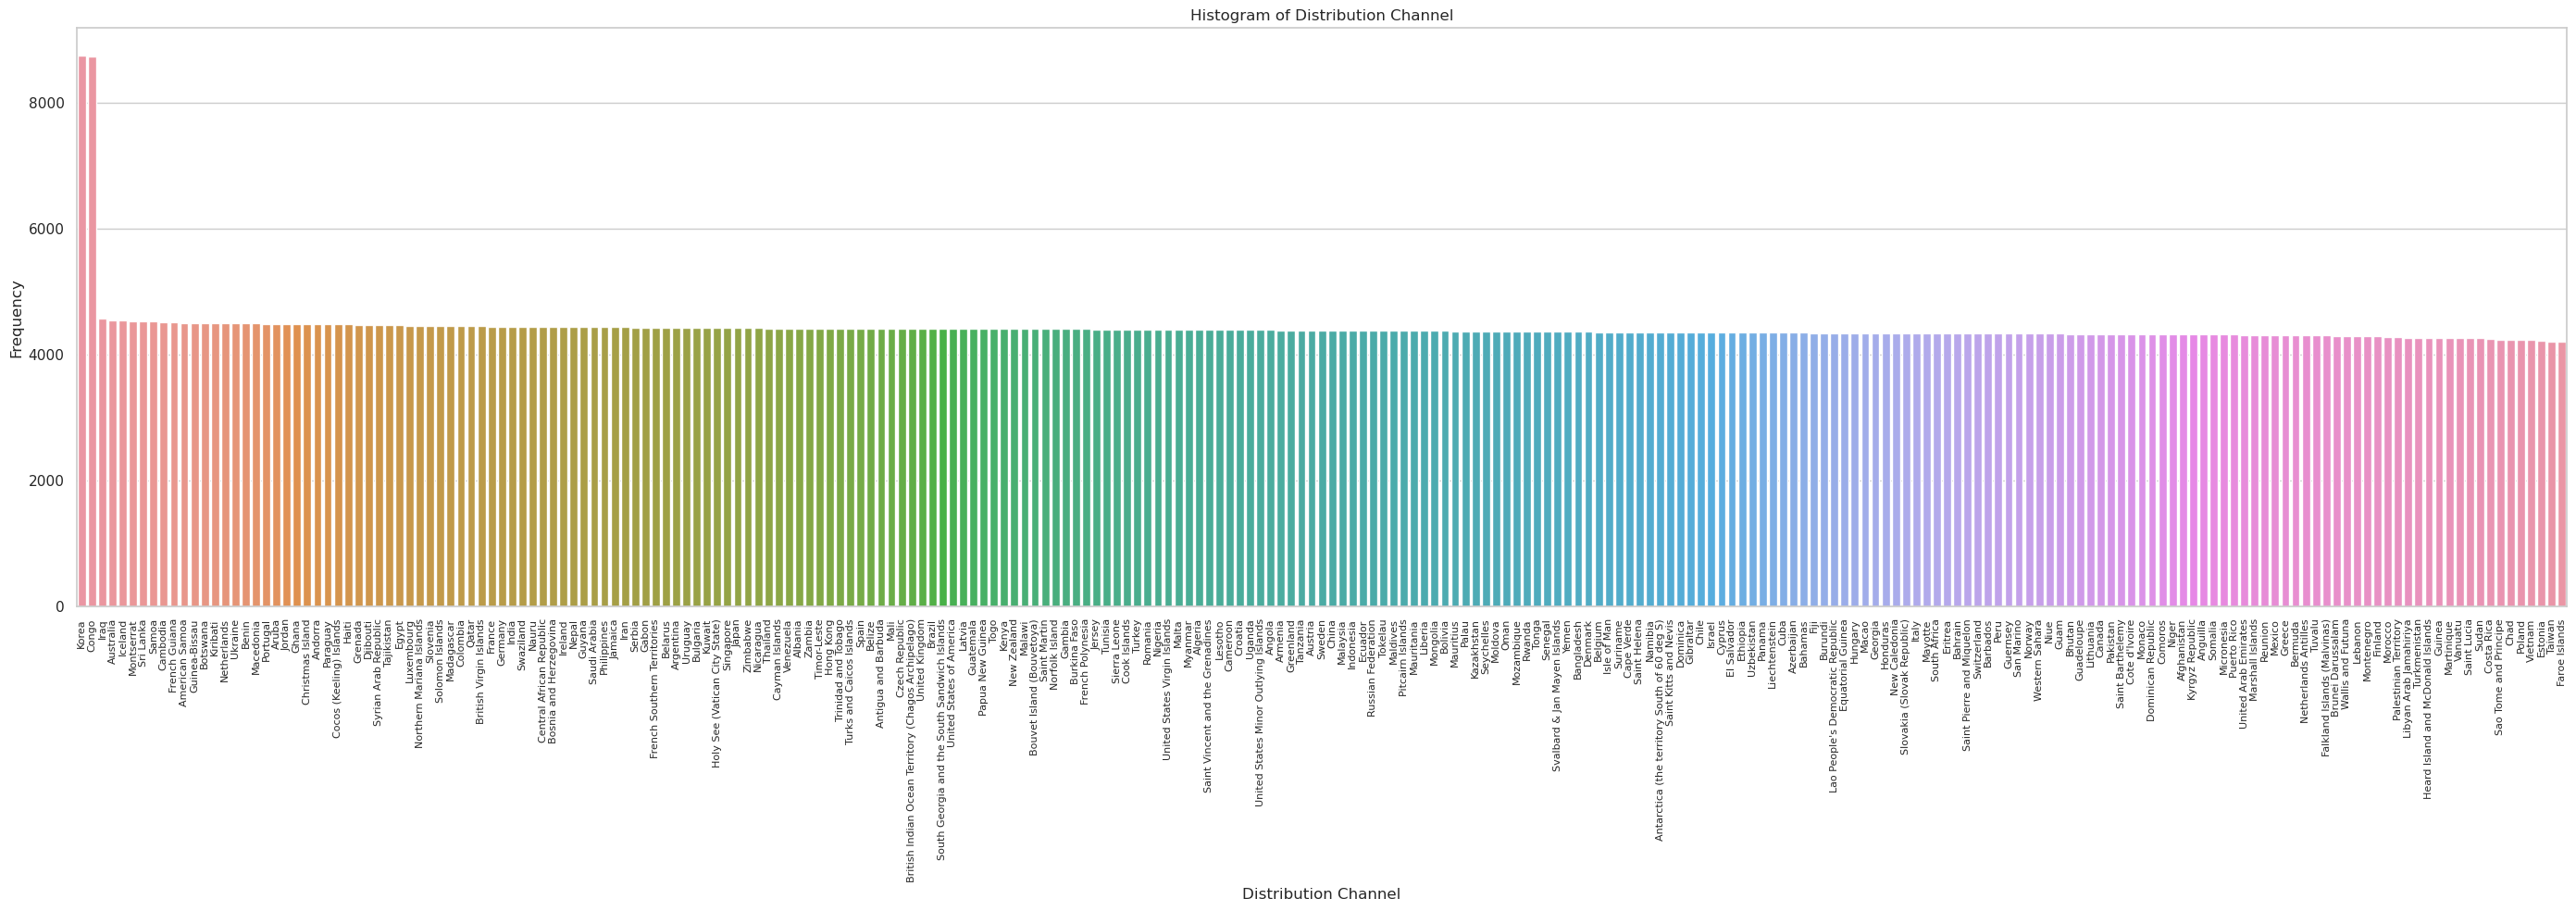

In [104]:
count = df['DISTRIBUTION_CHANNEL'].value_counts()
count = count.sort_values(ascending=False)
plt.figure(figsize=(28, 10))
sns.set(style="whitegrid")
sns.barplot(x=count.index, y=count.values)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Distribution Channel')
plt.ylabel('Frequency')
plt.title('Histogram of Distribution Channel')
plt.tight_layout()
plt.show()


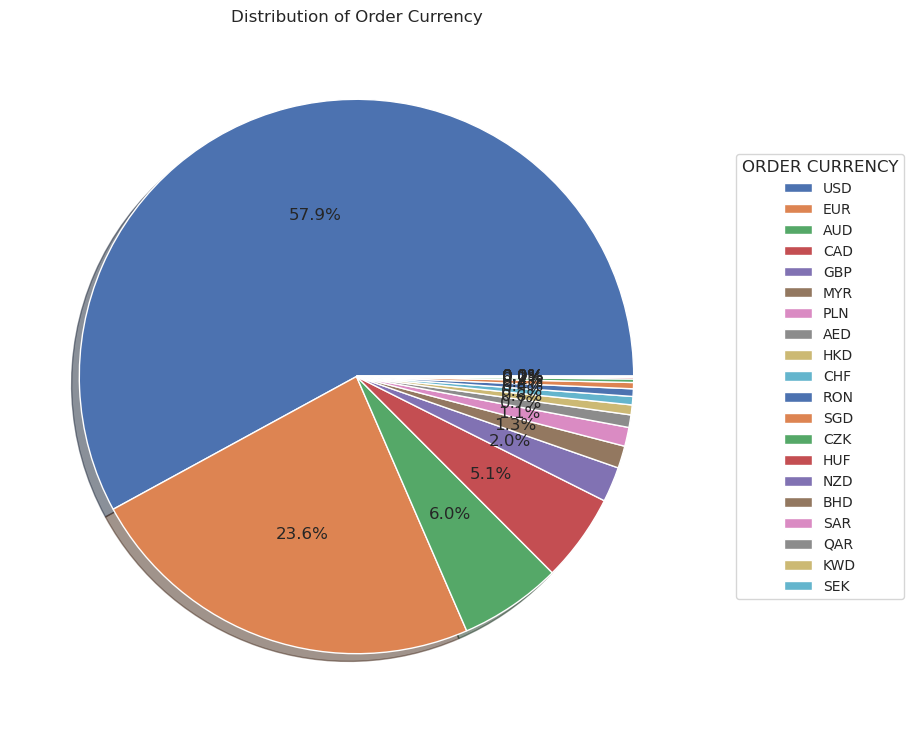

In [105]:
order_currency_counts = df['ORDER_CURRENCY'].value_counts()
plt.subplots(figsize=(15, 9))
plt.pie(order_currency_counts, shadow=True, autopct='%1.1f%%')
plt.legend(title='ORDER CURRENCY', labels=order_currency_counts.index,
           loc='right', bbox_to_anchor=(1.3, 0.5), fontsize=10)
plt.title('Distribution of Order Currency')

plt.show()

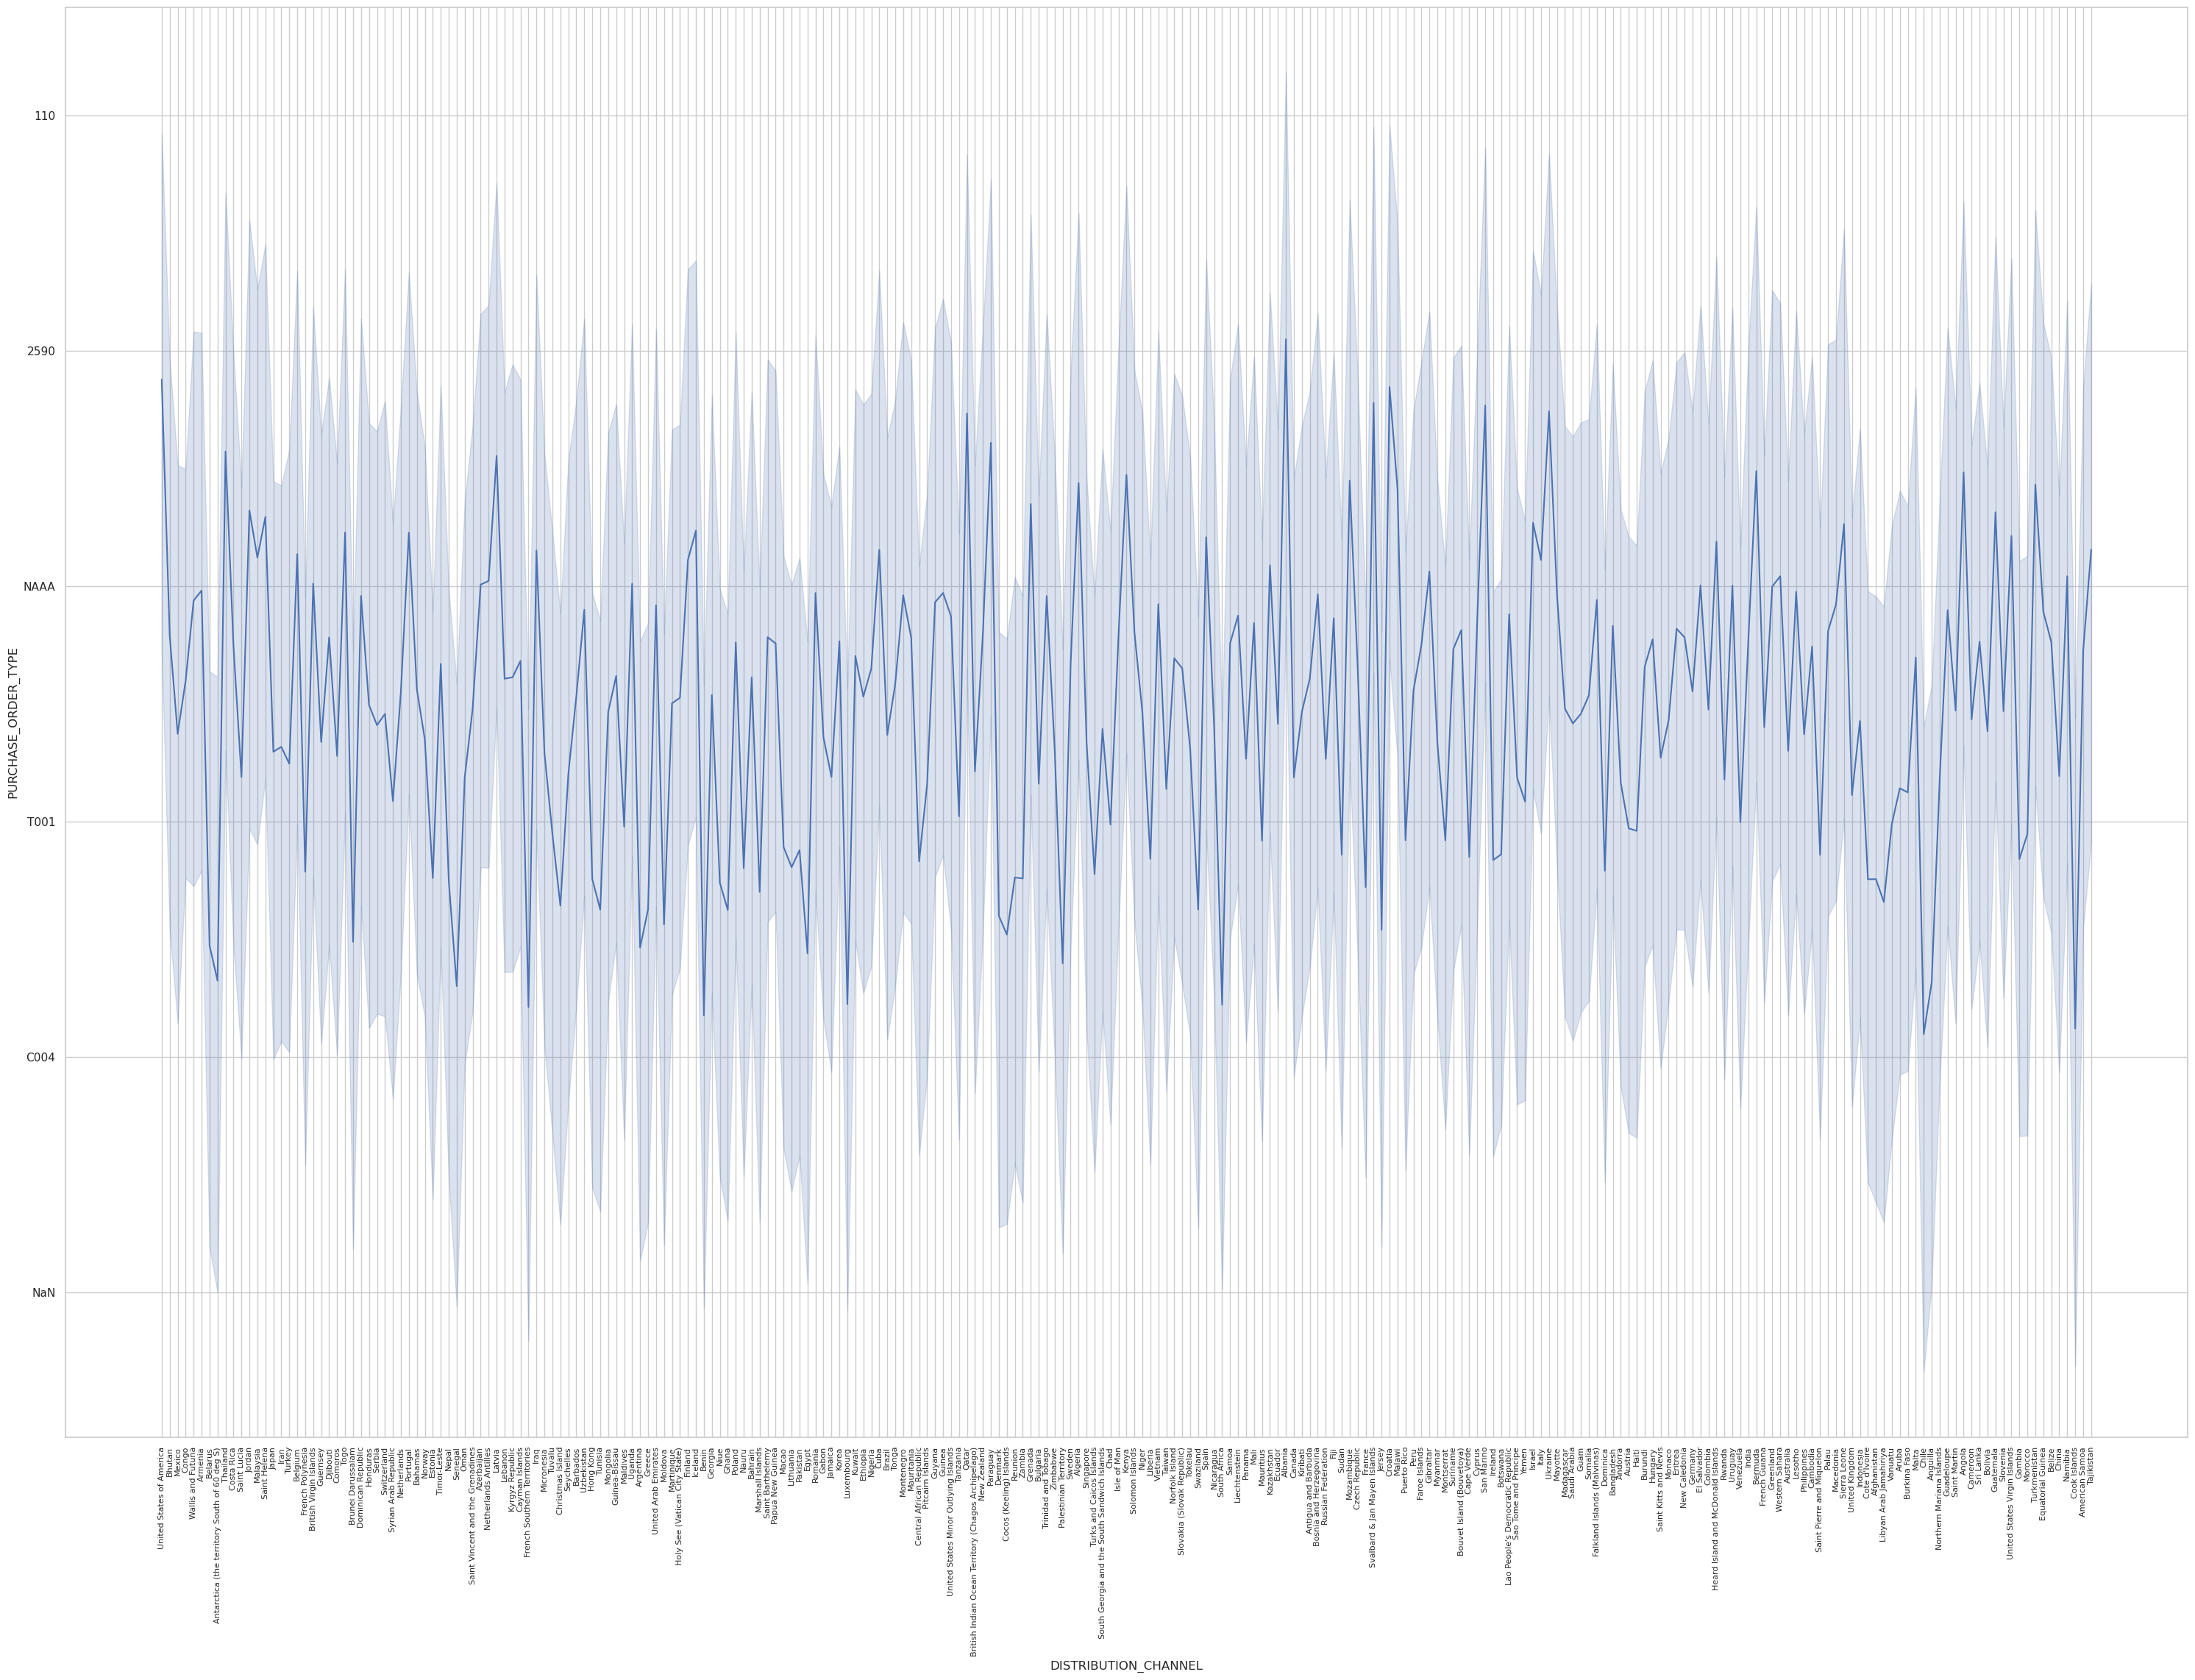

In [106]:
plt.figure(figsize=(30, 23))
sns.lineplot(data=df, x='DISTRIBUTION_CHANNEL', y='PURCHASE_ORDER_TYPE')
plt.xticks(fontsize=8, rotation=90)
plt.tight_layout()
plt.show()

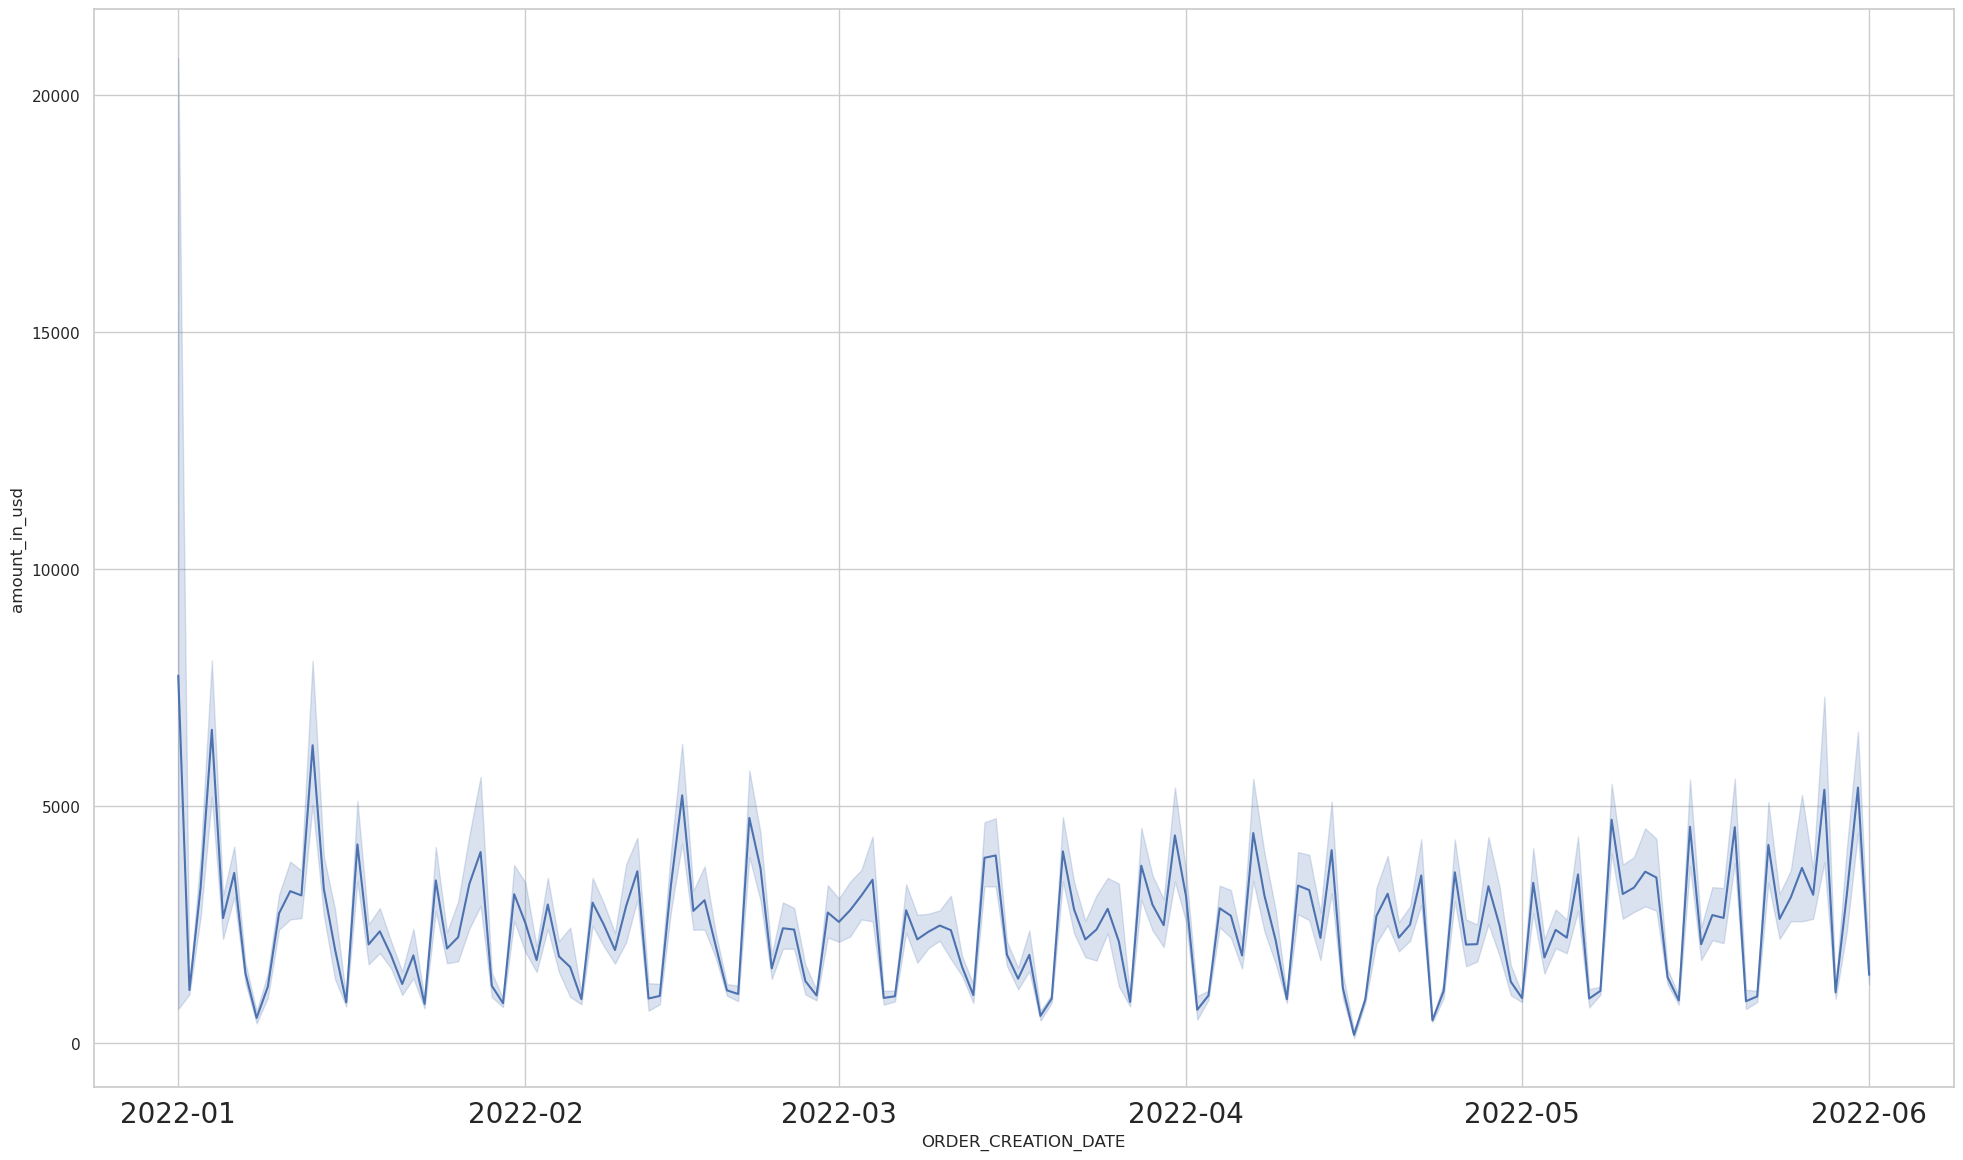

In [107]:
plt.figure(figsize=(24, 14))
sns.lineplot(data=df, x='ORDER_CREATION_DATE', y='amount_in_usd')
plt.xticks(fontsize=20)
plt.show()

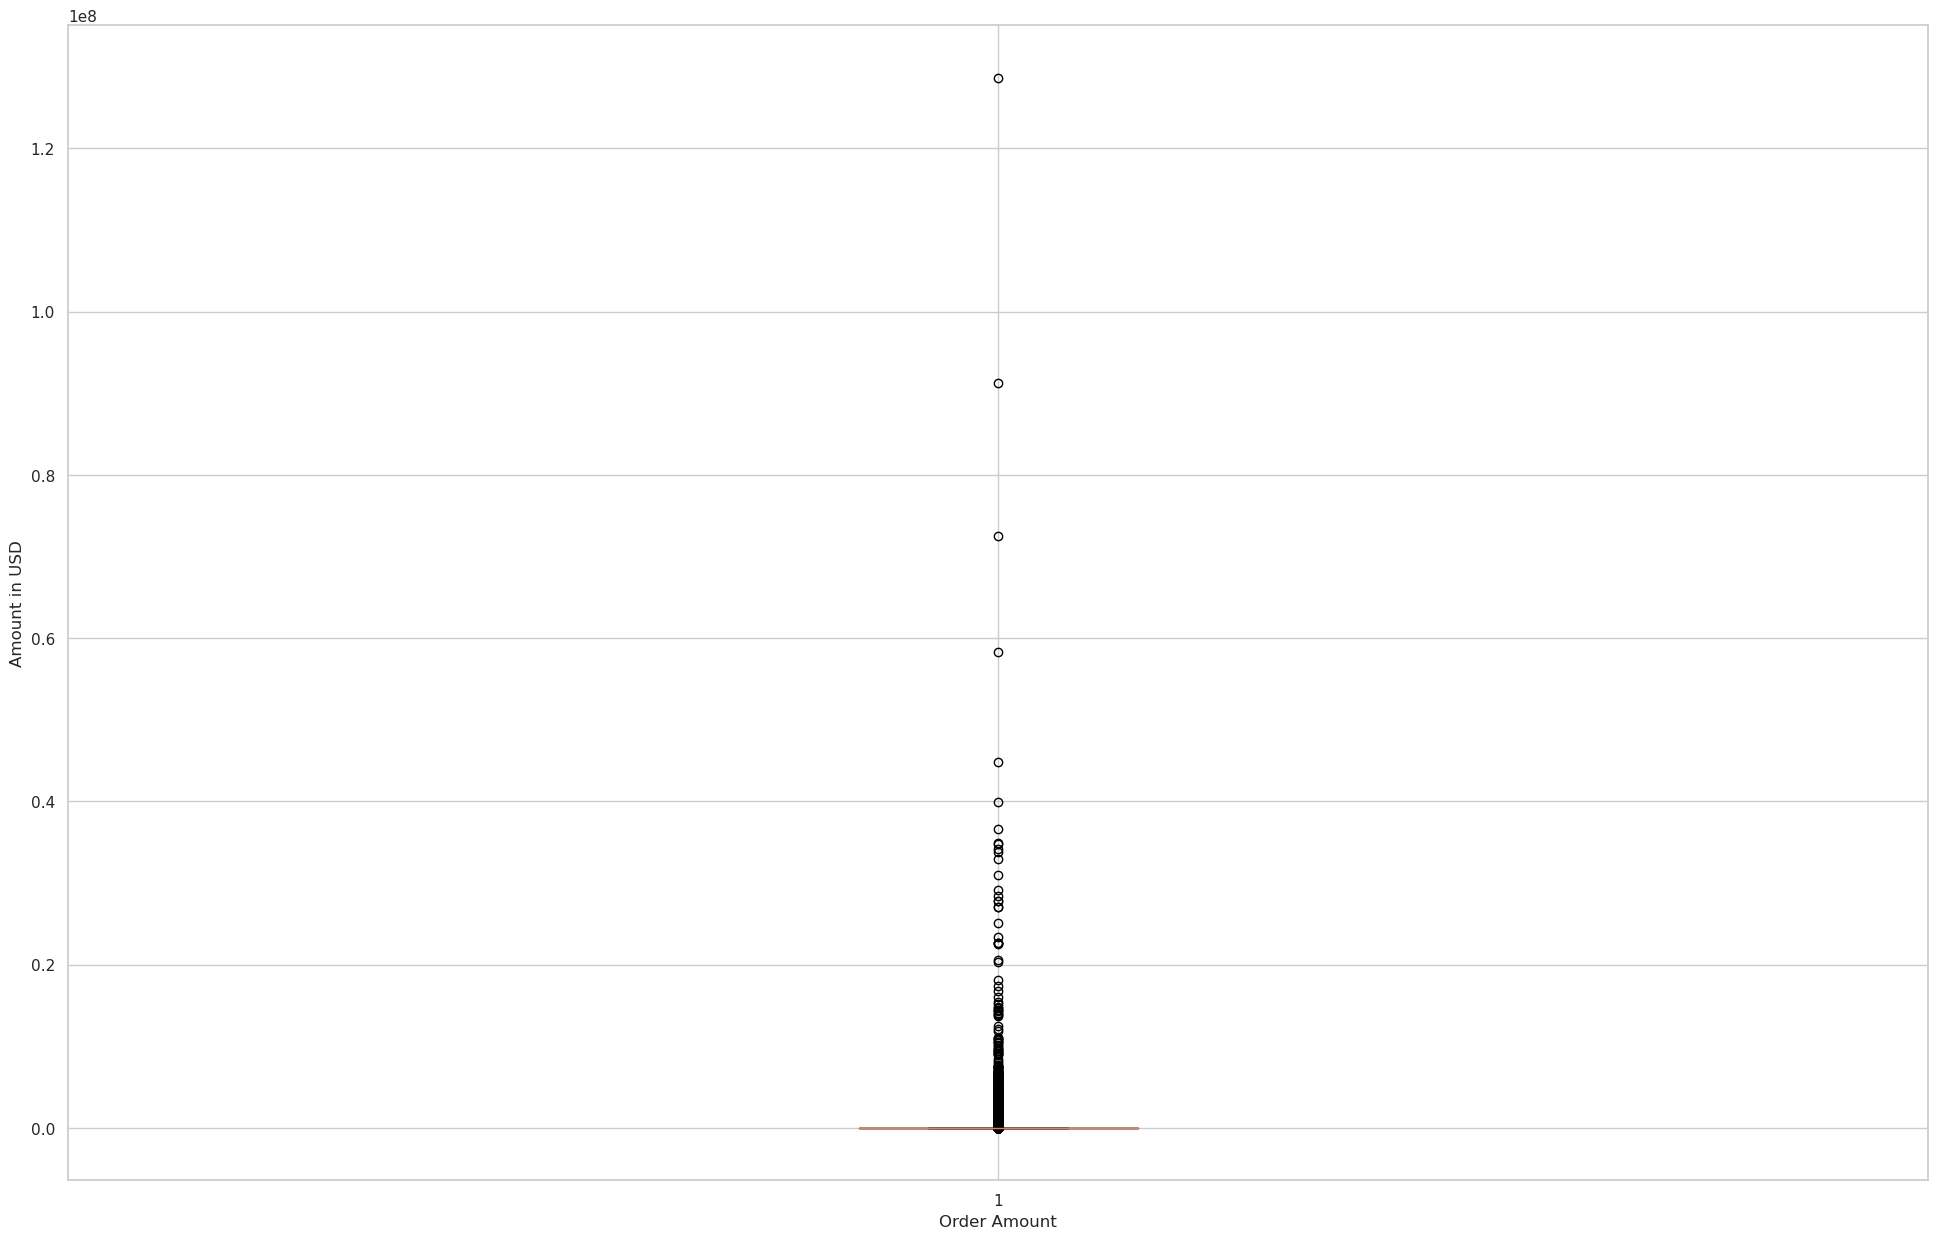

In [108]:
plt.figure(figsize=(24, 15))
plt.boxplot(df['ORDER_AMOUNT'].astype(float))
plt.xlabel('Order Amount')
plt.ylabel('Amount in USD')
plt.show()

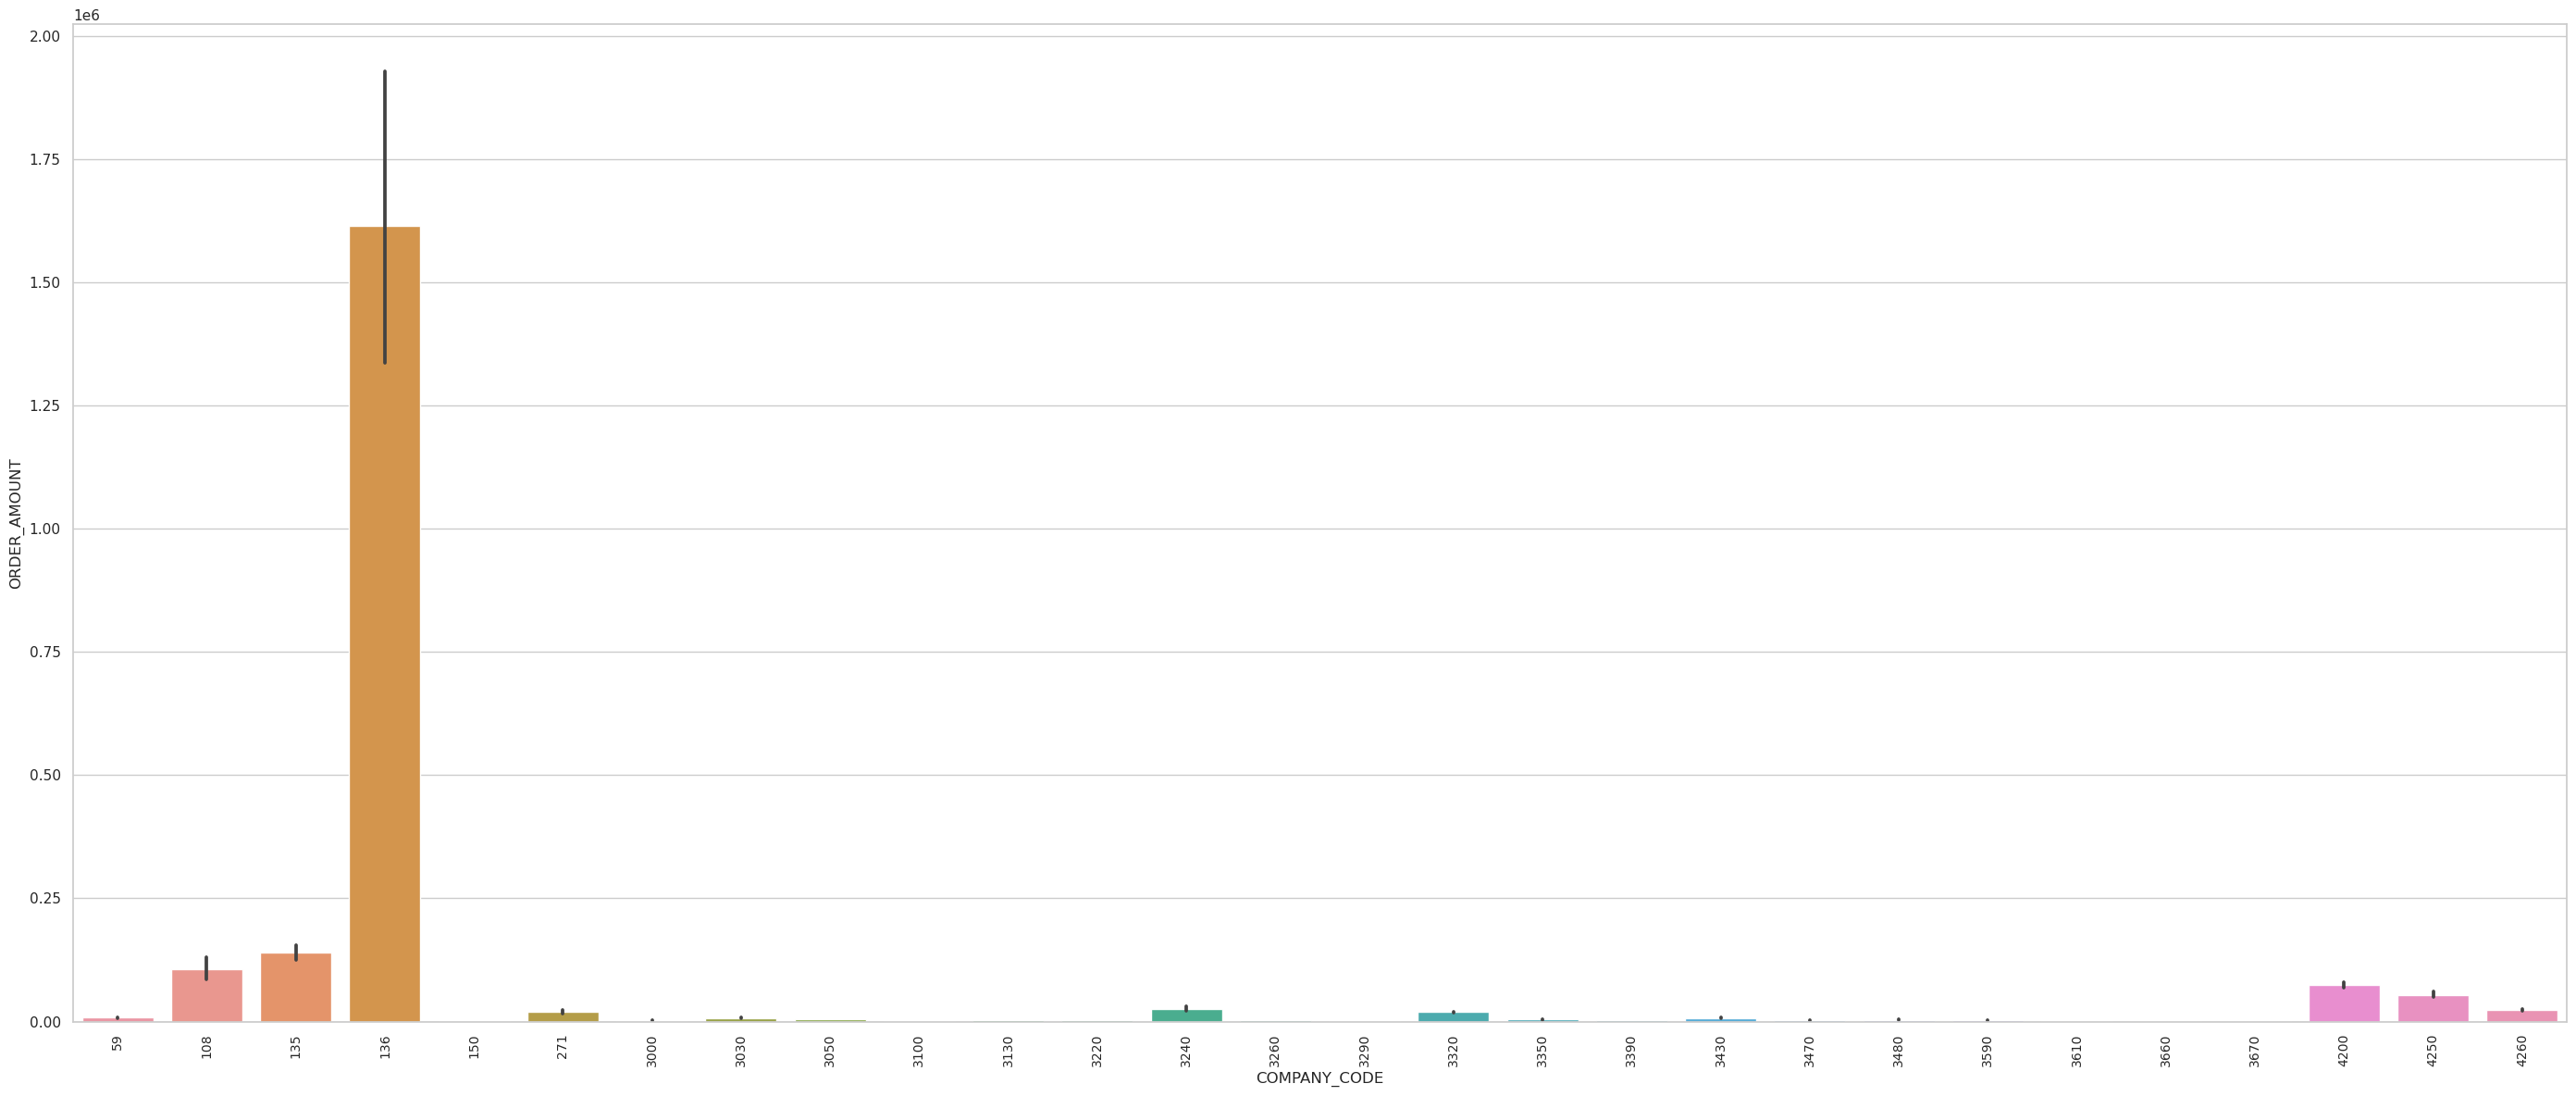

In [109]:
df = df.sort_values(by=['ORDER_AMOUNT'], ascending=False)
plt.figure(figsize=(28, 12))
sns.set(style="whitegrid")
sns.barplot(x=df['COMPANY_CODE'], y=df['ORDER_AMOUNT'].astype(float), data=df)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## Finding and removing outliers
 

In [110]:
#Using IQR to find suitable upper and lower bound of data 
Q1 = train_data.amount_in_usd.astype(float).quantile(0.25)
Q3 = train_data.amount_in_usd.astype(float).quantile(0.75)
IQR = Q3-Q1
lb = (Q1-2.2*IQR)
ub = (Q3+2.2*IQR)

print(str(lb)+" "+str(ub))
# mean_replace = np.mean(train_data[~((train_data.amount_in_usd.astype(float) < lb) | (train_data.amount_in_usd.astype(float) > ub))]['amount_in_usd'].astype(float))
# print(str(mean_replace))

#Replacing outliers with the upperbound as all the outliers are values that are more than the upper bound and the data is skewed with lots of zeroes
#So it is better to replace with upper bound as compared to mean

train_data['amount_in_usd'].loc[(train_data['amount_in_usd'] < lb) | (train_data['amount_in_usd'] > ub)]=ub

-1542.5003047361945 2289.4214076173944


/tmp/ipykernel_9532/816853717.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['amount_in_usd'].loc[(train_data['amount_in_usd'] < lb) | (train_data['amount_in_usd'] > ub)]=ub


## Creating new Features

In [111]:
# Creating columns for the Last 7 day sales and  difference in sales
def difference_in_days(melt, lags, ffday, customer_id_col, create_date_col, net_amount_col):
    for i in range(ffday, lags+1):
        melt['Last-'+str(i)+'day_Sales'] = melt.groupby([customer_id_col])[net_amount_col].shift(i)

    melt = melt.reset_index(drop = True)

    for i in range(ffday, lags+1):
        melt['Last-'+str(i)+'day_Diff']  = melt.groupby([customer_id_col])['Last-'+str(i)+'day_Sales'].diff()
    melt = melt.fillna(0)
    return melt

train_data = difference_in_days(train_data,7,1,'UNIQUE_CUST_ID','ORDER_CREATION_DATE','amount_in_usd')
test_data = difference_in_days(test_data,7,1,'UNIQUE_CUST_ID','ORDER_CREATION_DATE','amount_in_usd')

In [112]:
# Creating columns for Expected Delivery Time
train_data['EXPECTED_DELIVERY_TIME'] = (train_data['REQUESTED_DELIVERY_DATE'] - train_data['ORDER_CREATION_DATE']).dt.days
test_data['EXPECTED_DELIVERY_TIME'] = (test_data['REQUESTED_DELIVERY_DATE'] - test_data['ORDER_CREATION_DATE']).dt.days

/tmp/ipykernel_9532/2372684104.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(),cmap='coolwarm',annot=False)


<Axes: >

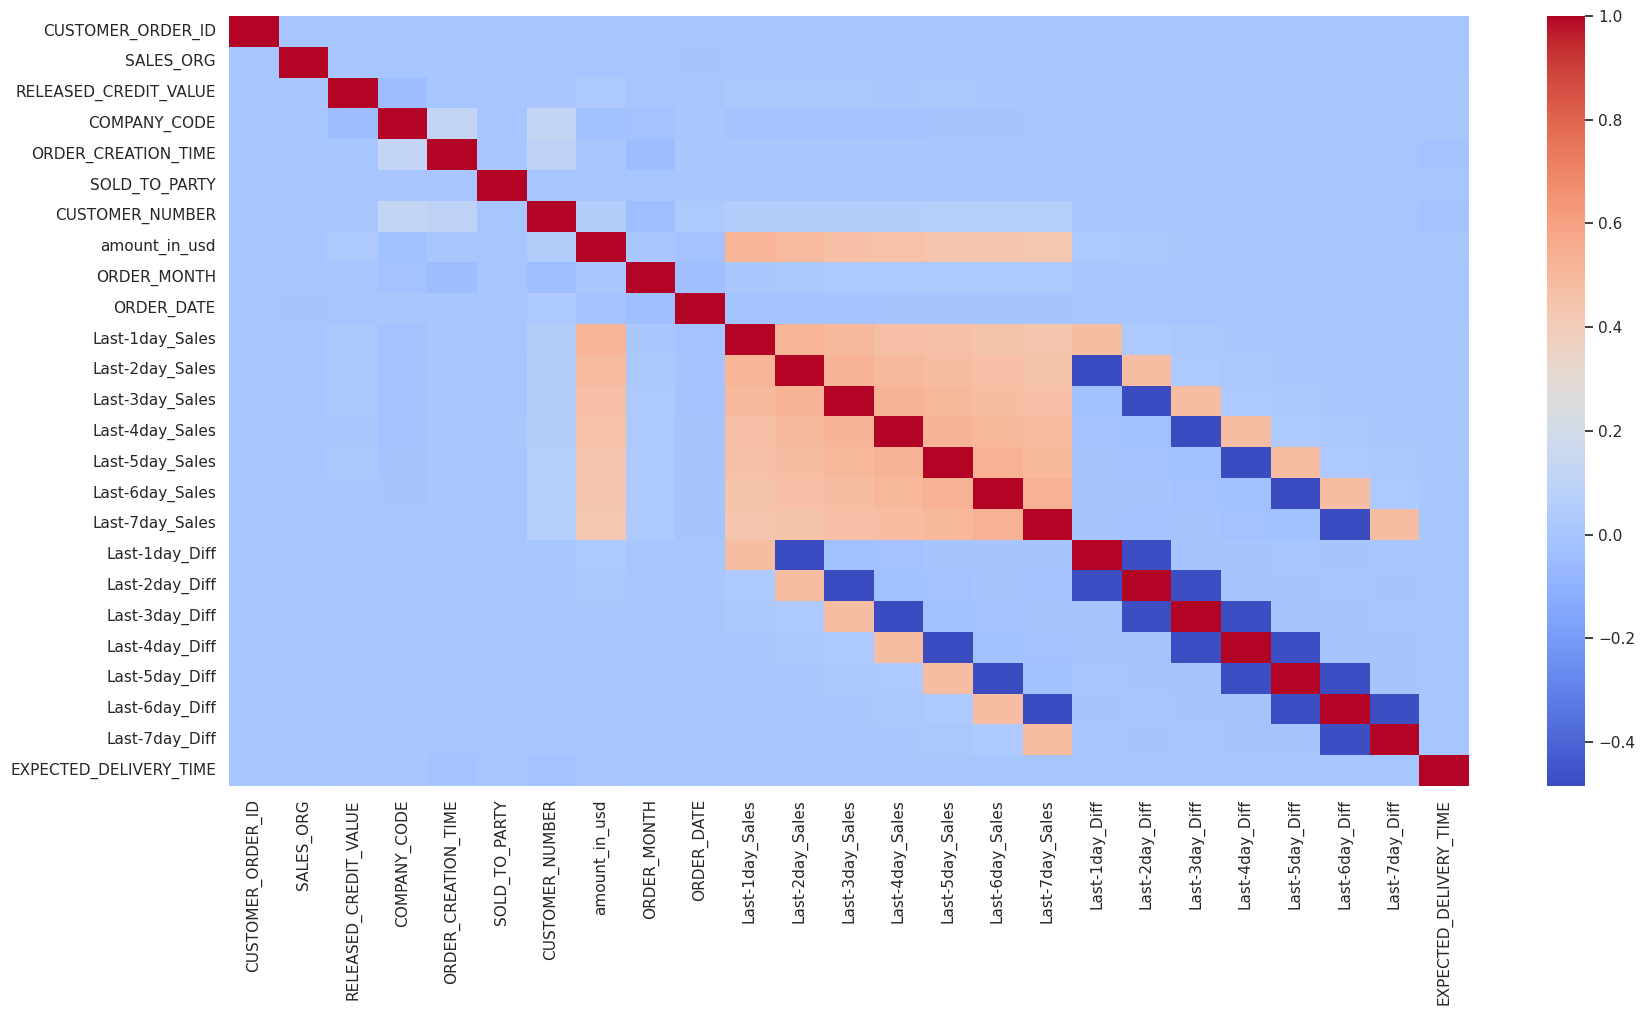

In [113]:
#Plotting heat map to find correlation between features
plt.figure(figsize=(20,10))
sns.heatmap(train_data.corr(),cmap='coolwarm',annot=False)

## ENCODING

In [114]:
#Label Encoding
categorical_columns = ['SALES_ORG', 'DISTRIBUTION_CHANNEL', 'DIVISION', 'CREDIT_CONTROL_AREA', 'CREDIT_STATUS','UNIQUE_CUST_ID']

le = LabelEncoder()
for column in categorical_columns:
    train_data[column] = le.fit_transform(train_data[column])
    dic = dict(zip(le.classes_, le.transform(le.classes_)))
    test_data[column]=test_data[column].map(dic).fillna(6474) # null values only exist for the UNIQUE_CUST_ID and in very little number so giving them a new unique number

## LOG Transformation

In [115]:
train_data['RELEASED_CREDIT_VALUE_LOG'] = np.where(train_data['RELEASED_CREDIT_VALUE'] > 0, np.log(train_data['RELEASED_CREDIT_VALUE']), train_data['RELEASED_CREDIT_VALUE'])
train_data['Last-1day_Sales_log'] = np.where(train_data['Last-1day_Sales'] > 0, np.log(train_data['Last-1day_Sales']), train_data['Last-1day_Sales'])
train_data['Last-2day_Sales_log'] = np.where(train_data['Last-2day_Sales'] > 0, np.log(train_data['Last-2day_Sales']), train_data['Last-2day_Sales'])
train_data['Last-3day_Sales_log'] = np.where(train_data['Last-3day_Sales'] > 0, np.log(train_data['Last-3day_Sales']), train_data['Last-3day_Sales'])
train_data['Last-4day_Sales_log'] = np.where(train_data['Last-4day_Sales'] > 0, np.log(train_data['Last-4day_Sales']), train_data['Last-4day_Sales'])
train_data['Last-5day_Sales_log'] = np.where(train_data['Last-5day_Sales'] > 0, np.log(train_data['Last-5day_Sales']), train_data['Last-5day_Sales'])
train_data['Last-6day_Sales_log'] = np.where(train_data['Last-6day_Sales'] > 0, np.log(train_data['Last-6day_Sales']), train_data['Last-6day_Sales'])
train_data['Last-7day_Sales_log'] = np.where(train_data['Last-7day_Sales'] > 0, np.log(train_data['Last-7day_Sales']), train_data['Last-7day_Sales'])


train_data['Last-1day_Sales_log'].fillna(0, inplace=True)
train_data['Last-2day_Sales_log'].fillna(0, inplace=True)
train_data['Last-3day_Sales_log'].fillna(0, inplace=True)
train_data['Last-4day_Sales_log'].fillna(0, inplace=True)
train_data['Last-5day_Sales_log'].fillna(0, inplace=True)
train_data['Last-6day_Sales_log'].fillna(0, inplace=True)
train_data['Last-7day_Sales_log'].fillna(0, inplace=True)

test_data['RELEASED_CREDIT_VALUE_LOG'] = np.where(test_data['RELEASED_CREDIT_VALUE'] > 0, np.log(test_data['RELEASED_CREDIT_VALUE']), test_data['RELEASED_CREDIT_VALUE'])
test_data['Last-1day_Sales_log'] = np.where(test_data['Last-1day_Sales'] > 0, np.log(test_data['Last-1day_Sales']), test_data['Last-1day_Sales'])
test_data['Last-2day_Sales_log'] = np.where(test_data['Last-2day_Sales'] > 0, np.log(test_data['Last-2day_Sales']), test_data['Last-2day_Sales'])
test_data['Last-3day_Sales_log'] = np.where(test_data['Last-3day_Sales'] > 0, np.log(test_data['Last-3day_Sales']), test_data['Last-3day_Sales'])
test_data['Last-4day_Sales_log'] = np.where(test_data['Last-4day_Sales'] > 0, np.log(test_data['Last-4day_Sales']), test_data['Last-4day_Sales'])
test_data['Last-5day_Sales_log'] = np.where(test_data['Last-5day_Sales'] > 0, np.log(test_data['Last-5day_Sales']), test_data['Last-5day_Sales'])
test_data['Last-6day_Sales_log'] = np.where(test_data['Last-6day_Sales'] > 0, np.log(test_data['Last-6day_Sales']), test_data['Last-6day_Sales'])
test_data['Last-7day_Sales_log'] = np.where(test_data['Last-7day_Sales'] > 0, np.log(test_data['Last-7day_Sales']), test_data['Last-7day_Sales'])



test_data['Last-1day_Sales_log'].fillna(0, inplace=True)
test_data['Last-2day_Sales_log'].fillna(0, inplace=True)
test_data['Last-3day_Sales_log'].fillna(0, inplace=True)
test_data['Last-4day_Sales_log'].fillna(0, inplace=True)
test_data['Last-5day_Sales_log'].fillna(0, inplace=True)
test_data['Last-6day_Sales_log'].fillna(0, inplace=True)
test_data['Last-7day_Sales_log'].fillna(0, inplace=True)

train_data['amount_in_usd_log'] = np.where(train_data['amount_in_usd'] > 0, np.log(train_data['amount_in_usd']), train_data['amount_in_usd'])
test_data['amount_in_usd_log'] = np.where(test_data['amount_in_usd'] > 0, np.log(test_data['amount_in_usd']), test_data['amount_in_usd'])

/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs

## FEATURE SCORING

In [116]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer

numerical_columns = ['SALES_ORG', 'RELEASED_CREDIT_VALUE', 'CREDIT_STATUS', 'RELEASED_CREDIT_VALUE_LOG', 'EXPECTED_DELIVERY_TIME','Last-1day_Sales_log','Last-2day_Sales_log','Last-3day_Sales_log','Last-4day_Sales_log','Last-5day_Sales_log','Last-6day_Sales_log','Last-7day_Sales_log']
X_numerical = train_data[numerical_columns]

imputer = SimpleImputer(strategy='mean')
X_numerical_imputed = imputer.fit_transform(X_numerical)

X = pd.DataFrame(X_numerical_imputed, columns=numerical_columns)
y = train_data['amount_in_usd']

mutual_info = mutual_info_regression(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mutual_info})
feature_scores = feature_scores.sort_values(by='Mutual_Information', ascending=False)

print(feature_scores)

                      Feature  Mutual_Information
5         Last-1day_Sales_log            1.140581
6         Last-2day_Sales_log            1.100060
7         Last-3day_Sales_log            1.070161
8         Last-4day_Sales_log            1.050978
9         Last-5day_Sales_log            1.033413
10        Last-6day_Sales_log            1.019121
11        Last-7day_Sales_log            1.006363
4      EXPECTED_DELIVERY_TIME            0.664745
3   RELEASED_CREDIT_VALUE_LOG            0.310040
1       RELEASED_CREDIT_VALUE            0.272550
2               CREDIT_STATUS            0.156770
0                   SALES_ORG            0.001543


## MODEL TRAINING AND TESTING

In [117]:
# Selecting features and creating the train and test sets
features = ['UNIQUE_CUST_ID','ORDER_MONTH','RELEASED_CREDIT_VALUE_LOG','EXPECTED_DELIVERY_TIME','SALES_ORG','CREDIT_STATUS','DISTRIBUTION_CHANNEL', 'DIVISION', 'CREDIT_CONTROL_AREA','Last-1day_Sales_log','Last-2day_Sales_log','Last-3day_Sales_log','Last-4day_Sales_log','Last-5day_Sales_log','Last-6day_Sales_log','Last-7day_Sales_log']

target = 'amount_in_usd_log'
X_train = train_data[features]
X_test = test_data[features]
y_train = train_data[target]
y_test = test_data[target]


In [120]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 40, #80-100
    'learning_rate': 0.04, #.06 -.07
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq':6,#3-5
    'verbose': 0
}
model = lgb.train(params,train_data,valid_sets=[valid_data],num_boost_round=1500,early_stopping_rounds=250,)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train - R-squared Score:", r2_train)
print("Train - Root Mean Squared Error:", rmse_train)
print("Test - R-squared Score:", r2_test)
print("Test - Root Mean Squared Error:", rmse_test)

/home/roxx/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 2.87259
Training until validation scores don't improve for 250 rounds
[2]	valid_0's rmse: 2.79731
[3]	valid_0's rmse: 2.72485
[4]	valid_0's rmse: 2.66016
[5]	valid_0's rmse: 2.59604
[6]	valid_0's rmse: 2.5366
[7]	valid_0's rmse: 2.47749
[8]	valid_0's rmse: 2.4214
[9]	valid_0's rmse: 2.37104
[10]	valid_0's rmse: 2.32267
[11]	valid_0's rmse: 2.27618
[12]	valid_0's rmse: 2.23246
[13]	valid_0's rmse: 2.19281
[14]	valid_0's rmse: 2.15332
[15]	valid_0's rmse: 2.11797
[16]	valid_0's rmse: 2.08334
[17]	valid_0's rmse: 2.04955
[18]	valid_0's rmse: 2.01682
[19]	valid_0's rmse: 1.98788
[20]	valid_0's rmse: 1.95867
[21]	valid_0's rmse: 1.93134
[22]	valid_0's rmse: 1.9054
[23]	valid_0's rmse: 1.88161
[24]	valid_0's rmse: 1.85856
[25]	valid_0's rmse: 1.83